In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data

In [2]:
df = pd.read_csv('boston.csv')
df.sample(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
249,0.19073,22.0,5.86,0,0.431,6.718,17.5,7.8265,7,330,19.1,393.74,6.56,26.2
443,9.96654,0.0,18.10,0,0.740,6.485,100.0,1.9784,24,666,20.2,386.73,18.85,15.4
124,0.09849,0.0,25.65,0,0.581,5.879,95.8,2.0063,2,188,19.1,379.38,17.58,18.8
456,4.66883,0.0,18.10,0,0.713,5.976,87.9,2.5806,24,666,20.2,10.48,19.01,12.7
108,0.12802,0.0,8.56,0,0.520,6.474,97.1,2.4329,5,384,20.9,395.24,12.27,19.8


In [3]:
df.shape

(506, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


# Split Data

In [5]:
# split train test
from sklearn.model_selection import train_test_split

fitur = df.drop(columns='medv')
target = df[['medv']]

# First splitting: pretrain and test
X_pretrain, X_test, y_pretrain, y_test = train_test_split(fitur, target, test_size=0.20, random_state=42)

# Second splitting: train and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_pretrain, y_pretrain, test_size=0.20, random_state=42)

# Menghitung nilai VIF dan korelasi

In [6]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(X_pretrain)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,1.713187
2,zn,2.465631
3,indus,3.877855
4,chas,1.096674
5,nox,4.469150
6,rm,1.947809
7,age,2.989948
8,dis,4.168578
9,rad,7.658316
10,tax,8.943301


Fitur 'nox', 'dis', 'rad', 'tax' memiliki nilai VIF Score yang cukup tinggi, sehingga ini perlu diatasi

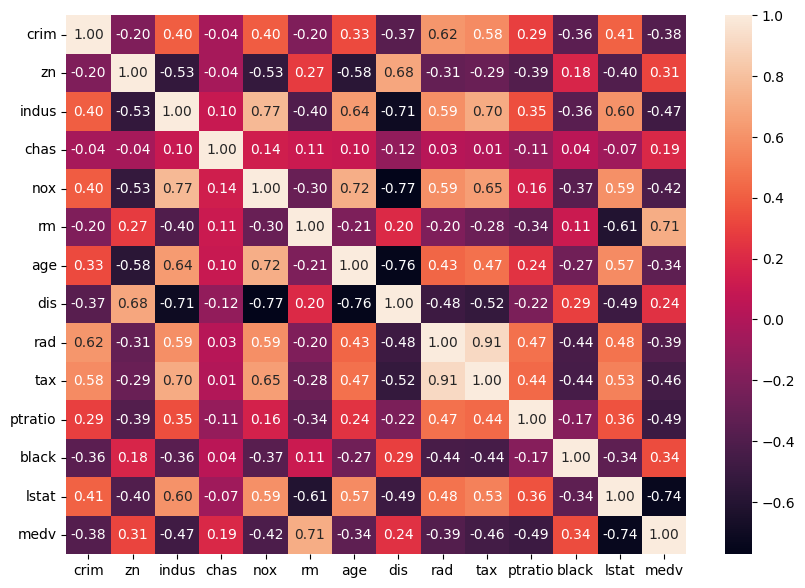

In [7]:
# heatmap correlation
price_train = pd.concat([X_pretrain, y_pretrain], axis=1)
corr = price_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Fitur-fitur yang memiliki korelasi tinggi antar sesama fitur:\
nox & dis = -0.77\
age & dis = -0.76\
rad & tax = 0.91\
Terlihat ada 2 kelompok yaitu saling berkorelasi negatif dan satu berkorelasi negatif\
Kelompok pertama ada 'nox', 'dis' dan 'age'\
Kelompok kedua ada 'tax' dan 'rad'

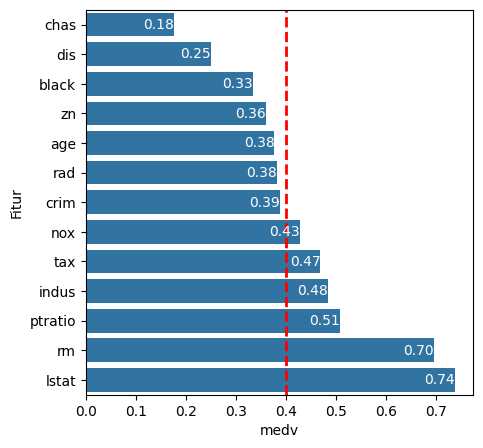

In [8]:
# Hitung korelasi terhadap variabel target
dataC = abs(df.corr())['medv'].sort_values().reset_index()
dataC = dataC[~dataC['index'].str.contains('medv')]
dataC = dataC.rename(columns={'index': 'Fitur'})

# Membuat horizontal barchart
plt.figure(figsize = (5,5))
barplot = sns.barplot(data = dataC.reset_index(), y='Fitur', x = 'medv')

# Menambahkan anotasi pada barchart
for index, value in enumerate(dataC['medv']):
    barplot.text(value, index, f'{value:.2f}', color='white', ha="right", va="center")

# Menambahkan threshold line sebesar 0.4 atau 40%
threshold = 0.4
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')

Treshold 40% diambil karena sebagian besar fitur menunjukkan korelasi yang rendah. Dengan menetapkan ambang batas pada 40%, kita ingin menyoroti hubungan yang lebih kuat antara fitur dan variabel target. Ini membantu memfokuskan analisis pada fitur-fitur yang memiliki dampak lebih signifikan dalam memprediksi variabel target, meminimalkan kompleksitas model, dan meningkatkan efisiensi dalam pemodelan regresi.

Kemudian akan diambil fitur yang memiliki korelasi diatas 40% dan tidak mengalami multikolinearitas\
Fitur tersebut adalah 'nox', 'tax', 'indus', 'pratio', 'rm', 'lstat'

In [9]:
collumn_sel = []
for i in range(len(dataC)):
    if dataC['medv'][i] > 0.4:
        collumn_sel.append(dataC['Fitur'][i])
collumn_sel

['nox', 'tax', 'indus', 'ptratio', 'rm', 'lstat']

In [10]:
X_pretrain = X_pretrain[collumn_sel]
X_train = X_train[collumn_sel]
X_validation = X_validation[collumn_sel]
X_test = X_test[collumn_sel]

Check VIF kembali untuk memastikan sudah tidak ada multikolinearitas antar fitur

In [11]:
X = add_constant(X_pretrain)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,nox,3.080798
2,tax,2.451342
3,indus,3.264496
4,ptratio,1.461615
5,rm,1.706711
6,lstat,2.424143


Bisa dilihat bahwa tidak ada lagi nilai VIF yang lebih dari 4

# Model Training

## Ridge Regression

In [12]:
from sklearn.linear_model import Ridge

# define the model
ridge_model_base = Ridge(alpha=0.1, random_state=42)

# fit the model (training)
ridge_model_base.fit(X_train, y_train)

Ridge(alpha=0.1, random_state=42)

In [13]:
# retrieve the coefficients
# show as a nice dataframe
data = X_train
model = ridge_model_base

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_[0]] + list(model.coef_[0])
})

coef_df

,feature,coefficient
0,intercept,11.911871
1,nox,-3.631527
2,tax,-0.004713
3,indus,0.147848
4,ptratio,-0.862487
5,rm,5.604389
6,lstat,-0.517863


### Train Multiple Models
to find the best alpha (lambda)

In [14]:
# define the model
# 4 models with 4 different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_train, y_train)
ridge_reg_pointone.fit(X_train, y_train)
ridge_reg_one.fit(X_train, y_train)
ridge_reg_ten.fit(X_train, y_train)

Ridge(alpha=10, random_state=42)

In [15]:
from sklearn.metrics import mean_squared_error

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_validation)
    rmse = np.sqrt(mean_squared_error(y_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 5.245002889955555
RMSE of Ridge regression model with alpha = 0.1 is 5.243376170235308
RMSE of Ridge regression model with alpha = 1.0 is 5.232046230845642
RMSE of Ridge regression model with alpha = 10 is 5.174943600598199


Bisa dilihat bahwa dengan alpha=10 mempunyai nilai RMSE yang paling kecil.\
Jadi model Regresi Ridge terbaik adalah dengan alpha=10

In [16]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_[0]] + list(ridge_best.coef_[0])
})

coef_df

,feature,coefficient
0,intercept,14.182070
1,nox,-0.435696
2,tax,-0.004928
3,indus,0.113408
4,ptratio,-0.847460
5,rm,5.078475
6,lstat,-0.560616


Interpretasi:
* intersep: Nilai **medv** ketika **fitur lainnya 0** adalah **14.182070**
* nox: **Koefisien negatif** menunjukkan bahwa semakin **rendah** nilai variabel "nox" semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** nox maka median harga rumah (medv) akan **turun** sebanyak **0.435696**.
* tax: **Koefisien negatif** menunjukkan bahwa semakin **rendah** nilai variabel "tax" semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** tax maka median harga rumah (medv) akan **turun** sebanyak **0.004928**.
* indus: **Koefisien positif** menunjukkan bahwa semakin **tinggi** nilai variabel "indus" semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** indus maka median harga rumah (medv) akan **naik** sebanyak **0.113408**
* pratio: **Koefisien negatif** menunjukkan bahwa semakin **rendah** nilai variabel "ptratio" (rasio murid-guru), semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** pratio maka median harga rumah (medv) akan **turun** sebanyak **0.847460**.
* rm: **Koefisien positif** menunjukkan bahwa semakin **tinggi** nilai variabel "rm" (rata-rata jumlah kamar per hunian), semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** rm maka median harga rumah (medv) akan **naik** sebanyak **5.078475**
* lstat: **Koefisien negatif** menunjukkan bahwa semakin **rendah** nilai variabel "lstat" (persentase penduduk status rendah), semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** lstat maka median harga rumah (medv) akan **turun** sebanyak **0.560616**

## Lasso Regression

In [17]:
from sklearn.linear_model import Lasso

# define the model
lasso_model_base = Lasso(alpha=0.1, random_state=42)

# fit the model (training)
lasso_model_base.fit(X_train, y_train)

Lasso(alpha=0.1, random_state=42)

In [18]:
# retrieve the coefficients
# show as a nice dataframe
data = X_train
model_lasso = lasso_model_base

coef_df_lasso = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model_lasso.intercept_[0]] + list(model_lasso.coef_)
})

coef_df_lasso

,feature,coefficient
0,intercept,12.007082
1,nox,-0.000000
2,tax,-0.005180
3,indus,0.105489
4,ptratio,-0.811324
5,rm,5.281909
6,lstat,-0.546712


### Train Multiple Models
to find the best alpha (lambda)

In [19]:
# define the model
# 4 models with 4 different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_train, y_train)
lasso_reg_pointone.fit(X_train, y_train)
lasso_reg_one.fit(X_train, y_train)
lasso_reg_ten.fit(X_train, y_train)

Lasso(alpha=10, random_state=42)

In [20]:
from sklearn.metrics import mean_squared_error

alphas_lasso = [0.01, 0.1, 1, 10]
models_lasso = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models_lasso, alphas_lasso):
    y_predict_validation_lasso = model.predict(X_validation)
    rmse_lasso = np.sqrt(mean_squared_error(y_validation,y_predict_validation_lasso))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse_lasso}')

RMSE of Lasso regression model with alpha = 0.01 is 5.232861843557517
RMSE of Lasso regression model with alpha = 0.1 is 5.192918381094414
RMSE of Lasso regression model with alpha = 1 is 4.97441257059597
RMSE of Lasso regression model with alpha = 10 is 5.443072335675602


Bisa dilihat bahwa dengan alpha=1 mempunyai nilai RMSE yang paling kecil.\
Jadi model Regresi Lasso terbaik adalah dengan alpha=1

In [21]:
lasso_best = lasso_reg_one

coef_df_lasso = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_[0]] + list(lasso_best.coef_)
})

coef_df_lasso

,feature,coefficient
0,intercept,28.758651
1,nox,0.000000
2,tax,-0.003633
3,indus,0.025954
4,ptratio,-0.755664
5,rm,2.746618
6,lstat,-0.665916


Interpretasi:
* intersep: Nilai **medv** ketika **fitur lainnya 0** adalah **28.758651**
* nox: karena koefisiennya adalah **0** menandakan bahaw nox **tidak memiliki dampak** terhadap **medv**
* tax: **Koefisien negatif** menunjukkan bahwa semakin **rendah** nilai variabel "tax," semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** tax maka median harga rumah (medv) akan **turun** sebanyak **0.003633**.
* indus: **Koefisien positif** menunjukkan bahwa semakin **tinggi** nilai variabel "indus" semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** indus maka median harga rumah (medv) akan **naik** sebanyak **0.025954**
* pratio: **Koefisien negatif** menunjukkan bahwa semakin **rendah** nilai variabel "ptratio" (rasio murid-guru), semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** pratio maka median harga rumah (medv) akan **turun** sebanyak **0.755664**.
* rm: **Koefisien positif** menunjukkan bahwa semakin **tinggi** nilai variabel "rm" (rata-rata jumlah kamar per hunian), semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** rm maka median harga rumah (medv) akan **naik** sebanyak **2.746618**
* lstat: **Koefisien negatif** menunjukkan bahwa semakin **rendah** nilai variabel "lstat" (persentase penduduk status rendah), semakin **tinggi** nilai variabel target (medv). Setiap **kenaikan satu** lstat maka median harga rumah (medv) akan **turun** sebanyak **0.665916**

# Model Evaluation

## Ridge Regression

### Training Error

In [22]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_train)

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train, y_predict_train)))

RMSE for training data is 5.191013365129996
MAE for training data is 3.711267810829218
MAPE for training data is 0.1888673199853856


### Testing Error

In [24]:
# prepare prediction result on test data
y_predict_test = ridge_best.predict(X_test)

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test, y_predict_test)))

RMSE for testing data is 5.280155973022674
MAE for testing data is 3.328237028497077
MAPE for testing data is 0.17544211118739653


## Lasso Regression

### Training Error

In [25]:
# prepare prediction result on train data
y_predict_lasso_train = lasso_best.predict(X_train)

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, y_predict_lasso_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train, y_predict_lasso_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train, y_predict_lasso_train)))

RMSE for training data is 5.451767870452234
MAE for training data is 3.969660995622143
MAPE for training data is 0.19031239575079964


### Testing Error

In [27]:
# prepare prediction result on test data
y_predict_lasso_test = lasso_best.predict(X_test)

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test, y_predict_lasso_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test, y_predict_lasso_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test, y_predict_lasso_test)))

RMSE for testing data is 5.119219949854917
MAE for testing data is 3.398864757656816
MAPE for testing data is 0.1713492080337014


## Interpret Evaluation

In [28]:
from sklearn.metrics import r2_score
evaluation = {
    'Model':['Ridge', 'Lasso'],
    'RMSE_train':[np.sqrt(mean_squared_error(y_train, y_predict_train)),np.sqrt(mean_squared_error(y_train, y_predict_lasso_train))],
    'RMSE_test':[np.sqrt(mean_squared_error(y_test, y_predict_test)),np.sqrt(mean_squared_error(y_test, y_predict_lasso_test))],
    'MAE_train':[mean_absolute_error(y_train, y_predict_train), mean_absolute_error(y_train, y_predict_lasso_train)],
    'MAE_test':[mean_absolute_error(y_test, y_predict_test), mean_absolute_error(y_test, y_predict_lasso_test)],    
    'MAPE_train':[mean_absolute_percentage_error(y_train, y_predict_train),mean_absolute_percentage_error(y_train, y_predict_lasso_train)],
    'MAPE_test':[mean_absolute_percentage_error(y_test, y_predict_test),mean_absolute_percentage_error(y_test, y_predict_lasso_test)],
}
evaluation = pd.DataFrame(evaluation)
evaluation

,Model,RMSE_train,RMSE_test,MAE_train,MAE_test,MAPE_train,MAPE_test
0,Ridge,5.191013,5.280156,3.711268,3.328237,0.188867,0.175442
1,Lasso,5.451768,5.119220,3.969661,3.398865,0.190312,0.171349


1. Regresi Ridge
* Lebih robust dengan perbedaan yang sangat tipis antara performa pada data training dan data test.
* Nilai MAE yang lebih baik daripada model Regresi Lasso baik pada saat data training maupun data test.
2. Regresi Lasso
* Meskipun perbedaan dengan data test sedikit lebih besar dibandingkan dengan model Ridge, hal ini menunjukkan kecenderungan model Lasso untuk overfitting ringan dibandingkan dengan Ridge.
* Menunjukkan performa yang baik dilihat dari nilai RMSE dan MAPE pada data test dibandingkan model Ridge.

Kesimpulan secara umum:
* Regresi Ridge dan Regresi Lasso menunjukkan hasil yang baik secara keseluruhan, dengan nilai evaluasi eror yang relatif kecil.
* Regresi Ridge menunjukkan robustness dengan perbedaan yang tipis antara data training dan data test.
* Regresi Lasso menunjukkan performa yang baik dari segi nilai RMSE dan MAPE pada data test.

# Model Diagnostic

## Ridge Regression

In [29]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_train).flatten()

print('R-squared for training data is {}'.format(r2_score(y_train, y_predict_train)))

R-squared for training data is 0.7033239955772144


R-squared (R2) sebesar 70.33% pada model regresi Ridge menunjukkan bahwa 70.33% variabilitas dalam variabel target dapat dijelaskan oleh fitur-fitur dalam model, menandakan tingkat kecocokan yang baik.

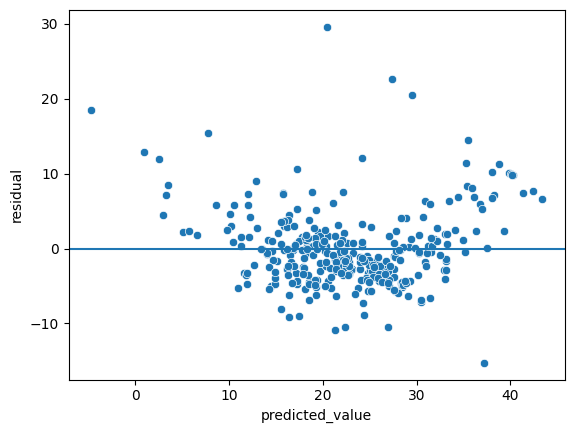

In [30]:
# calculate residuals
residual_ridge = y_train.values.flatten() - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual_ridge
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Asumsi:
1. Linear relationship: OK. Garis horizontal y=0 cukup merepresentasikan keseluruhan titik residual.
2. Variance stable: sebenarnya tidak terlalu jelas apakah ada pola atau tidak, akan diperiksa dengan uji Breusch Pagan
3. Independent residual: OK. Tidak ada pattern yang mencolok pada residuals yang berdekatan.

### Uji Breusch Pagan

Hipotesis Uji Breusch-Pagan\
H0: Varians residual konstan\
H1: Varians residual tidak konstan atau bervariasi\
dengan kriteria uji tolak H0 ketika p-value<alpha\
alpha/taraf signifikansi yang digunakan adalah 0.05

In [35]:
#Uji breuschpagan untuk mengetahui kekonstanan varians (homoskedastisitas)
from statsmodels.stats.diagnostic import het_breuschpagan
X_check = add_constant(X_train)
_, p_value, _, _ = het_breuschpagan(residual_ridge, X_check)
p_value

0.0005151715887974118

didapat nilai p-value < alpha sehingga berhasil menolak H0\
menandakan bahwa varians residual model Ridge tidak konstan

## Lasso Regression

In [31]:
y_predict_train_lasso = lasso_best.predict(X_train).flatten()
print('R-squared for training data is {}'.format(r2_score(y_train, y_predict_train_lasso)))

R-squared for training data is 0.6727702059921309


R-squared (R2) sebesar 67.28% pada model regresi Lasso menunjukkan bahwa sekitar 67.28% variabilitas dalam variabel target dapat dijelaskan oleh fitur-fitur dalam model tersebut.
Meskipun model regresi Lasso memiliki R2 sebesar 67.28%, nilai ini sedikit lebih rendah dibandingkan dengan model regresi Ridge yang memiliki R2 sebesar 70.33%, menunjukkan kinerja yang relatif lebih baik pada model Ridge.

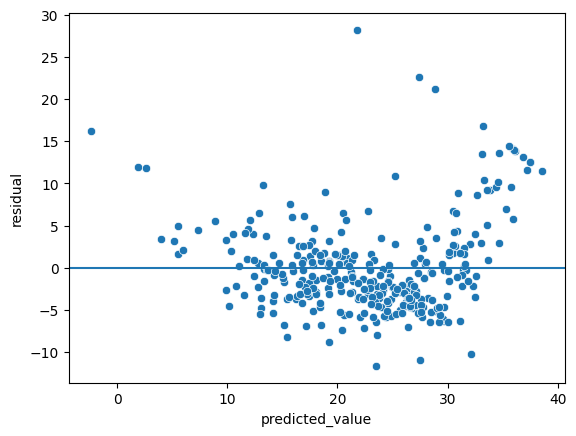

In [32]:
# calculate residuals
residual_lasso = y_train.values.flatten() - y_predict_train_lasso

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train_lasso,
    'residual': residual_lasso
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Asumsi:
1. Linear relationship: OK. Garis horizontal y=0 cukup merepresentasikan keseluruhan titik residual.
2. Variance stable: sebenarnya tidak terlalu jelas apakah ada pola atau tidak, akan diperiksa dengan uji Breusch Pagan
3. Independent residual: OK. Tidak ada pattern yang mencolok pada residuals yang berdekatan. 

Hipotesis Uji Breusch-Pagan\
H0: Varians residual konstan\
H1: Varians residual tidak konstan atau bervariasi\
dengan statistik uji tolak H0 ketika p-value<alpha\
alpha/taraf signifikansi yang digunakan adalah 0.05

In [62]:
#Uji breuschpagan untuk mengetahui kekonstanan varians (homoskedastisitas)
from statsmodels.stats.diagnostic import het_breuschpagan
X_check = add_constant(X_train)
_, p_value, _, _ = het_breuschpagan(residual_lasso, X_check)
p_value

8.538447648337308e-06

didapat nilai p-value < alpha sehingga berhasil menolak H0\
menandakan bahwa varians residual model Lasso tidak konstan